In [1]:
#pip install pyproj
#pip install netdcf4
import os
import netCDF4 as nc
import numpy as np
import matplotlib.pyplot as plt
import pdb
import scipy.spatial.qhull as qhull
from scipy.interpolate import griddata
import pyproj
from u_interpolate_small import regrid_irregular_quick
from datetime import date
from ndays import numOfDays
import glob
#from mpl_toolkits.basemap import Basemap

In [2]:
# Define domain and time period
start_lat = -37
end_lat = -10
start_lon = -18
end_lon = 30
start_month = '01'
start_year = '2010'
end_month = '01'
end_year = '2010'

In [3]:
dir_name = '/prj/Africa_cloud/ch9_wavelet/'+start_year+'/'+start_month+'/'
os.chdir(dir_name)

In [4]:
# find indices using one file
core_filename = '/prj/Africa_cloud/ch9_wavelet/2010/09/201009081045.nc'
core_data = nc.Dataset(core_filename,'r')
# read in cores lat/lon
lat = np.array(core_data.variables['lat'][:])
lon = np.array(core_data.variables['lon'][:])
#lon_filter = lon >-181 # acceptable values
#lon_fl = lon[lon_filter] #filtered long
lat_ind = np.where((lat>=start_lat) & (lat<=end_lat))[0]
lon_ind = np.where((lon>= start_lon) & (lon<=end_lon))[0]
lat = lat[lat_ind[0]:lat_ind[-1]]
lon = lon[lon_ind[0]:lon_ind[-1]]
#lon = lon_fl[(lon_fl>= start_lon) & (lon_fl<=end_lon)]
X, Y = np.meshgrid(lon,lat)


# find ndays
date1 = date(int(start_year), int(start_month), 1)
date2 = date(int(end_year), int(end_month), 2)
t = numOfDays(date1, date2)
#time = 
cores = np.zeros((len(lat),len(lon),t*24),dtype=float) #using every fourth value for hourly comparison- 24hr
#time = np.zeros((len(lat)-1,len(lon)-1,t*96))

In [5]:
# read in cores data
list_of_files = sorted(os.listdir())
counter = 0
for l in range(2, t*96, 4):#range(len(list_of_files)): # 96 files per day
    core_filename = '/prj/Africa_cloud/ch9_wavelet/'+start_year+'/'+start_month+'/'+list_of_files[l]
    core_data = nc.Dataset(core_filename,'r')
    #print(core_data)
    cores_temp = np.array(core_data.variables['cores'])[0,lat_ind[0]:lat_ind[-1],lon_ind[0]:lon_ind[-1]]
    cores[:,:,counter] = cores_temp   
    counter = counter+1
    core_data.close()                                                                                                                                                

In [6]:
# find precip indices using one file
precip_filename = '/prj/global_water/MCS_Feng/global_v2/2d_fields/20100101.0000_20110101.0000/mcstrack_20100901_0630.nc'
precip_data = nc.Dataset(precip_filename,'r')
lat_p = np.array(precip_data.variables['latitude'][:])
lon_p = np.array(precip_data.variables['longitude'][:])
lat_ind_p = np.where((lat_p[:,1]>=start_lat) & (lat_p[:,1]<=end_lat))[0]
lon_ind_p = np.where((lon_p[1,:]>= start_lon) & (lon_p[1,:]<=end_lon))[0]
lat_p = lat_p[lat_ind_p[0]:lat_ind_p[-1],lon_ind_p[0]:lon_ind_p[-1]]
lon_p = lon_p[lat_ind_p[0]:lat_ind_p[-1],lon_ind_p[0]:lon_ind_p[-1]]
#X_p, Y_p = np.meshgrid(lon_p,lat_p)

In [7]:
# read in precip data 
dir_name_precip =  '/prj/global_water/MCS_Feng/global_v2/2d_fields/'+start_year+'0101.0000_'+str(int(start_year)+1)+'0101.0000'
os.chdir(dir_name_precip)
list_of_files_precip = sorted(glob.glob("mcstrack_"+start_year+start_month+"01*.nc")) # day 1
precip = np.zeros((len(lat_p[:,1]),len(lon_p[1,:]),t*24),dtype=float)
regidded_precip = np.zeros((len(lat),len(lon),t*24),dtype=float)

for l in range(0,len(list_of_files_precip),1):
    precip_filename = list_of_files_precip[l]
    precip_data = nc.Dataset(precip_filename,'r')
    precip_temp = np.array(precip_data.variables['precipitation'])[0,lat_ind_p[0]:lat_ind_p[-1],lon_ind_p[0]:lon_ind_p[-1]]
    precip[:,:,l] = precip_temp                                                                                                                                                            
    A = regrid_irregular_quick(lon_p[1,:],lat_p[:,1],lon,lat,precip_temp)
    regidded_precip[:,:,l] = A   

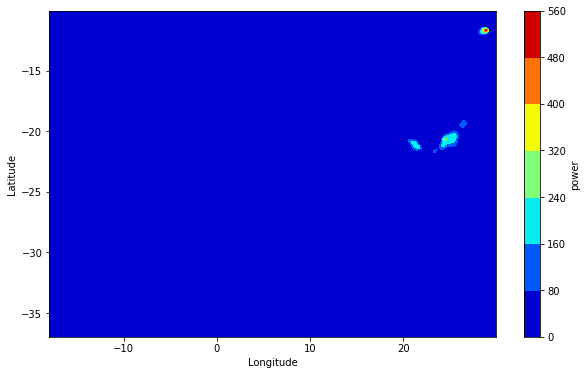

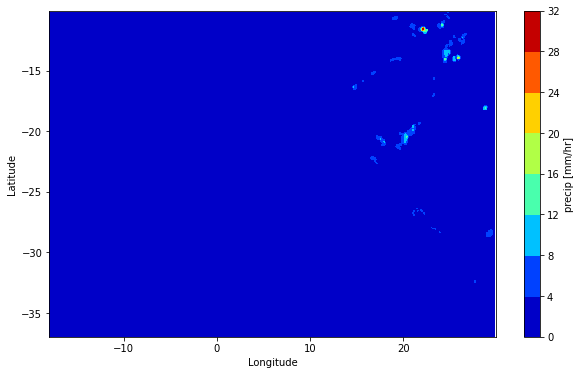

In [9]:
# visualize core data at inherent grid/resol
plt.figure(figsize=(10,6))
plt.contourf(X,Y,cores[:,:,0],cmap='jet')
plt.colorbar(label='power')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()

# visualize core data at inherent grid/resol
#plt.figure(figsize=(10,6))
#plt.contourf(lon_p,lat_p,precip[:,:,1],cmap='jet')#
#plt.colorbar(label='precip [mm/hr]')
#plt.xlabel('Longitude')
#plt.ylabel('Latitude')
#plt.show()

# visualize core data at inherent grid/resol
plt.figure(figsize=(10,6))
plt.contourf(X,Y,regidded_precip[:,:,0],cmap='jet')#
plt.colorbar(label='precip [mm/hr]')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()

In [10]:
# calculate frequency of rainfall above a threshold 
# dat = 
# threshold = 30mm/hr

def calc_treshReached(dat, thresh):
    return np.sum(np.array(dat)>thresh)/np.sum(np.isfinite(dat))

In [11]:
# calculate frequency of rainfall above a threshold relative to the same frequency for the full rainfall field (native)

def calc_treshReached_vsObs(dat, obs, thresh):
    return np.sum(np.array(dat)>thresh)/np.sum(np.isfinite(dat)) / np.sum(np.array(obs)>thresh)/np.sum(np.isfinite(obs))

In [12]:
# calculate fraction of missed rainfall pixels above a threshold

def calc_treshMissed(dat, obs, thresh):
    return np.sum(np.array(dat)>thresh)/np.sum(np.array(obs)>thresh)

In [13]:
# calculate frequency of rainfall above a threshold for regions with wavelet power above a given percentile

def percentile(dat, wav, thresh, perc):
    pval = np.percentile(wav, perc)
    dats = np.array(dat)[np.array(wav)>=pval]
    return np.sum(dats>thresh)/np.sum(np.isfinite(dats))

In [14]:
def calc_treshMissed(dat, obs, thresh):
    return np.sum(np.array(dat)>thresh)/np.sum(np.array(obs)>thresh)

In [ ]:
# Basics to start with would be fraction of retained intense / extreme rainfall pixels  (e.g. > 40 mm) and curves 
# that show the probability for rain above a threshold (slide 3 in attached) - the latter being what we're trying to
# maximise while retaining most intense rainfall pixels from the original rainfall field.
# The curves represent rainfall associated with different versions of our convective cores (blue, yellow, green, red)
# and the stats for the original IMERG rainfall field interpolated to a 3 and 5km regular grid (interpolation 
# effect test..). 

In [16]:
# threshold exceeded
dat = regidded_precip.flatten()
treached = calc_treshReached(dat,20)
print(treached)

3.081329852663132e-06


In [ ]:
tcaught = []
for i in range(0,t*24,1)
        precip = strt['5k rain']
    
    tcaught = calc_treshMissed(dat,precip, 30)
    print(cc, dat, len(dat))
    tcaught.append(cc)

In [ ]:
tfrac = []
for dat in [(k3LS['rain'], '3km LS, 3k weighting', alls3k), (k3LS_grid['rain'], '3km LS, nflics weighting', alls3k), (k3['rain'], '3km small, 3kweighting', alls3k), (k3LS_nflics['rain'], '3km LS, 3k regridded, 3k weighting', alls3k_reg), (nflics['rain'], '5k, nflics', alls5k), (nflicsLS['rain'], '5k LS definition, nflics weighting', alls5k)]:

    cc = calc_treshReached_vsObs(dat[0],dat[2], 25)
    print(cc, dat[1])
    tfrac.append(cc)

In [ ]:
f = plt.figure(figsize=(9,6), dpi=200)
ax = f.add_subplot(111)
plotdic = []
for dat in [(k3LS, '3km LS, new weighting'), (k3LS_grid, '3km LS, nflics weighting'), (nflics, '5k nflics'), (nflicsLS, '5k LS, nflics weighting')]:
    treached = []
    for intens in range(5,50,5):
        cc = percentile(dat[0]['rain'],dat[0]['wav'], intens, 75)
        treached.append(cc)
    plotdic.append((treached,dat[1]))

for pp in plotdic:    
    ax.plot(range(5,50,5), pp[0], label=pp[1])

ax.set_title("Intensity probability for 75th centile power (%) (x[treshhold]/x)")
plt.legend()
#f.savefig("/home/ck/DIR/cornkle/data/nflics/core_tests/"+'rainP_75p_wpower.jpg')

In [24]:
# read cores daily data
#core_filename = '/prj/Africa_cloud/ch9_wavelet/2010/06/201006081045.nc'
#core_filename = '/prj/Africa_cloud/ch9_wavelet/2010/',month,'/201006081045.nc'
#core_data = nc.Dataset(core_filename,'r')
#print(core_data)
#cores_temp = np.array(core_data.variables['cores'])
#cores = np.array(core_data.variables['cores'])
#time = core_data.variables['time'][:]

#cores = cores.append(cores_temp)
# make a lat x lon x time dataset for monthly cores
#global_attributes = core_data.__dict__


# read precip data
#precip_filename = '/prj/global_water/MCS_Feng/global_v2/2d_fields/'
#precip_data = nc.Dataset(precip_filename,'r')

# visualize core data at inherent grid/resol
#plt.figure(figsize=(10,6))
#plt.contourf(X,Y,np.max(cores,axis=2),cmap='jet')
#plt.colorbar(label='power')
#plt.title(cores.time)
#plt.xlabel('Longitude')
#plt.ylabel('Latitude')
#plt.show()

# visualize regridded data
# plt.figure(figsize=(10,6))
#plt.contourf(X_new,Y_new,A,cmap='jet')
#plt.colorbar(label='power')
#plt.title(cores.time)
#plt.xlabel('Longitude')
#plt.ylabel('Latitude')
#plt.show()

In [ ]:
# replace with precip data grid - bring coarse precip data (0.1) to fine core grid (0.04)
#new_lat = np.linspace(min(lat),max(lat),2000)#(lat[2]-lat[1])*2)
#new_lon = np.linspace(min(lon),max(lon),1900)#(lat[2]-lat[1])*2)
#X_new, Y_new = np.meshgrid(new_lon,new_lat)
#A = regrid_irregular_quick(lat_p,lon_p,lon,lat,cores_temp)
#regidded_precip[:,:,l] = A    